# Computing Pairwise Coherence for Resting State Data 
Created: 03/14/2024 by A Fink \
Updated: 03/18/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
from mne_connectivity import spectral_connectivity_time
from mne_connectivity.viz import plot_sensors_connectivity
from mne_connectivity import spectral_connectivity_epochs,phase_slope_index,seed_target_indices,check_indices
import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GitHub/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
date = datetime.date.today().strftime('%m%d%Y')
print(date)

04012024


## Epoch continuous resting state data
- load bipolar rereferenced lfp data
- crop data to 7 minutes, starting from 10 seconds into recording 
- epoch data into 10 second increments (gives 42 epochs)

In [6]:
# Specify root directory for un-archived data and results 
base_dir      = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/resting_state_proj/resting_state_ieeg/'
anat_dir      = f'{base_dir}anat/'
neural_dir    = f'{base_dir}/preprocess/clean_data/'
subj_info_dir = f'{base_dir}patient_tracker/'

subj_ids = list(pd.read_excel(f'{subj_info_dir}subjects_master_list.xlsx', usecols=[0]).PatientID)


In [7]:
bp_lfp_all_subj = {}
epochs_all_subj = {}


for subj_id in subj_ids:
    bp_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/{subj_id}_bp_ref_ieeg.fif', preload=False)
    bp_data.crop(tmin=10,tmax=430)
    bp_lfp_all_subj[subj_id] = bp_data
    epochs = mne.make_fixed_length_epochs(bp_data, duration=10, preload=False)
    epochs.save(f'{neural_dir}{subj_id}/{subj_id}_bp_epochs.fif', overwrite=True)
    epochs_all_subj[subj_id] = epochs
    


Opening raw data file /Users/alexandrafink/Documents/GraduateSchool/SaezLab/resting_state_proj/resting_state_ieeg//preprocess/clean_data/MS001/MS001_bp_ref_ieeg.fif...
    Range : 0 ... 304687 =      0.000 ...   609.374 secs
Ready.
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Overwriting existing file.
Loading data for 42 events and 5000 original time points ...
0 bad epochs dropped
Loading data for 1 events and 5000 original time points ...
Loading data for 42 events and 5000 original time points ...
Opening raw data file /Users/alexandrafink/Documents/GraduateSchool/SaezLab/resting_state_proj/resting_state_ieeg//preprocess/clean_data/MS003/MS003_bp_ref_ieeg.fif...
    Range : 0 ... 309624 =      0.000 ...   619.248 secs
Ready.
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Overwriting existing file.
Loading data for 42 events and 5000 original time points ...
0 bad 

    Range : 0 ... 303249 =      0.000 ...   606.498 secs
Ready.
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Overwriting existing file.
Loading data for 42 events and 5000 original time points ...
0 bad epochs dropped
Loading data for 1 events and 5000 original time points ...
Loading data for 42 events and 5000 original time points ...
Opening raw data file /Users/alexandrafink/Documents/GraduateSchool/SaezLab/resting_state_proj/resting_state_ieeg//preprocess/clean_data/MS024/MS024_bp_ref_ieeg.fif...
    Range : 0 ... 303249 =      0.000 ...   606.498 secs
Ready.
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Overwriting existing file.
Loading data for 42 events and 5000 original time points ...
0 bad epochs dropped
Loading data for 1 events and 5000 original time points ...
Loading data for 42 events and 5000 original time points ...
Opening raw data file /Users/ale

In [8]:
epochs_all_subj
##event_related_plot = epochs.plot_image(picks=["MEG 1142"]) #visualization if wanted

{'MS001': <Epochs |  42 events (all good), 0 - 9.998 sec, baseline off, ~116 kB, data not loaded,
  '1': 42>,
 'MS003': <Epochs |  42 events (all good), 0 - 9.998 sec, baseline off, ~142 kB, data not loaded,
  '1': 42>,
 'MS006': <Epochs |  42 events (all good), 0 - 9.998 sec, baseline off, ~125 kB, data not loaded,
  '1': 42>,
 'MS007': <Epochs |  42 events (all good), 0 - 9.998 sec, baseline off, ~196 kB, data not loaded,
  '1': 42>,
 'MS008': <Epochs |  42 events (all good), 0 - 9.998 sec, baseline off, ~141 kB, data not loaded,
  '1': 42>,
 'MS010': <Epochs |  42 events (all good), 0 - 9.998 sec, baseline off, ~137 kB, data not loaded,
  '1': 42>,
 'MS012': <Epochs |  42 events (all good), 0 - 9.998 sec, baseline off, ~100 kB, data not loaded,
  '1': 42>,
 'MS014': <Epochs |  42 events (all good), 0 - 9.998 sec, baseline off, ~73 kB, data not loaded,
  '1': 42>,
 'MS016': <Epochs |  42 events (all good), 0 - 9.998 sec, baseline off, ~117 kB, data not loaded,
  '1': 42>,
 'MS017': <

In [9]:
bp_lfp_all_subj

{'MS001': <Raw | MS001_bp_ref_ieeg.fif, 61 x 210001 (420.0 s), ~116 kB, data not loaded>,
 'MS003': <Raw | MS003_bp_ref_ieeg.fif, 83 x 210001 (420.0 s), ~141 kB, data not loaded>,
 'MS006': <Raw | MS006_bp_ref_ieeg.fif, 72 x 210001 (420.0 s), ~125 kB, data not loaded>,
 'MS007': <Raw | MS007_bp_ref_ieeg.fif, 117 x 210001 (420.0 s), ~196 kB, data not loaded>,
 'MS008': <Raw | MS008_bp_ref_ieeg.fif, 81 x 210001 (420.0 s), ~141 kB, data not loaded>,
 'MS010': <Raw | MS010_bp_ref_ieeg.fif, 78 x 210001 (420.0 s), ~137 kB, data not loaded>,
 'MS012': <Raw | MS012_bp_ref_ieeg.fif, 54 x 210001 (420.0 s), ~99 kB, data not loaded>,
 'MS014': <Raw | MS014_bp_ref_ieeg.fif, 34 x 210001 (420.0 s), ~73 kB, data not loaded>,
 'MS016': <Raw | MS016_bp_ref_ieeg.fif, 65 x 210001 (420.0 s), ~117 kB, data not loaded>,
 'MS017': <Raw | MS017_bp_ref_ieeg.fif, 58 x 210001 (420.0 s), ~105 kB, data not loaded>,
 'MS018': <Raw | MS018_bp_ref_ieeg.fif, 93 x 210001 (420.0 s), ~168 kB, data not loaded>,
 'MS019': <

https://mne.tools/dev/generated/mne.make_fixed_length_epochs.html#mne.make_fixed_length_epochs
https://mne.tools/dev/auto_tutorials/epochs/60_make_fixed_length_epochs.html#sphx-glr-auto-tutorials-epochs-60-make-fixed-length-epochs-py

## Format data to compute intra/inter-region coherence
https://mne.tools/mne-connectivity/stable/auto_examples/connectivity_classes.html#sphx-glr-auto-examples-connectivity-classes-py
- look into MIM for calculating coherence https://www.sciencedirect.com/science/article/pii/S1053811913004096?casa_token=_hdR17SYsvAAAAAA:aVimSU3Uy3mnKvAz-dV99k1nuk3BaDbgRBtyv-pX3UPCM4MvXQlzwd8rgThYuqcREU4W85olHQ https://mne.tools/mne-connectivity/stable/auto_examples/mic_mim.html#sphx-glr-auto-examples-mic-mim-py
- mne suggests this function for resting state connectivity -
https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.spectral_connectivity_time.html#mne_connectivity.spectral_connectivity_time
https://mne.tools/mne-connectivity/stable/auto_examples/compare_connectivity_over_time_over_trial.html#sphx-glr-auto-examples-compare-connectivity-over-time-over-trial-py over spectral_connectivity_epochs 
https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.spectral_connectivity_epochs.html

If bandpass filtering is needed #https://mne.tools/dev/auto_tutorials/preprocessing/30_filtering_resampling.html#tut-filter-resample
#epochs.load_data().filter(l_freq=8, h_freq=12)

Resource for comparing epochs/time + visualization https://mne.tools/mne-connectivity/stable/auto_examples/compare_connectivity_over_time_over_trial.html#sphx-glr-auto-examples-compare-connectivity-over-time-over-trial-py

In [10]:
def find_elec_rois(anat_df,reref_ch_names,roi_label_info):
    """
    Get ROI info for bipolar reref elecs

    Parameters
    ----------
    anat_df : pandas.DataFrame
        anatomical reconstruction dataframe for single subj 
    reref_ch_names : list
        List of bipolar-reref channel names 
    roi_label_info : pandas.DataFrame
        Dataframe of custom ROI labels for Saez lab from YBA atlas (consider making a path & loading in fn)

    Returns
    -------
    final_anat_df : pandas.DataFrame
        Updated anat_df with one row for every reref_ch_name that contains ROI, hemisphere, final_loc info, subj_id
    wm_error_df : pandas.DataFrame
        Dataframe containing any reref_ch_names where both anode-cathode are in wm (hopefully empty)
    """ 
    
    # make anat_df labels lowercase 
    anat_df['label'] = anat_df['label'].str.lower()
    # add hemisphere info to anat_df 
    anat_df['hemi'] = [row['label'].lower()[0] for index, row in anat_df.iterrows()]
    anat_df = anat_df[(anat_df['hemi']=='r')|(anat_df['hemi']=='l')]
    # make final_loc info lowercase & remove extra spaces
    anat_df['final_loc'] = anat_df['final_loc'].str.lower()
    anat_df['final_loc'] = anat_df['final_loc'].str.strip()
    # extract anode/cathode channel labels from ch names
    anode_elecs = pd.Series(ch_names).str.split('-').str[0]
    cathode_elecs = pd.Series(ch_names).str.split('-').str[1]
    # make separate anode/cathode dfs 
    anode_df = anat_df[anat_df.label.str.lower().isin(anode_elecs)]
    anode_df['reref_ch_name'] = anode_df.label.apply(lambda x: [a for a in ch_names if str(x).lower() in a.split('-')[0]][0])
    cathode_df = anat_df[anat_df.label.str.lower().isin(cathode_elecs)]
    cathode_df['reref_ch_name'] =  cathode_df.label.apply(lambda x: [a for a in ch_names if str(x).lower() in a.split('-')[1]][0])
    # find anodes/cathodes in wm
    wm_labels = ['wm', 'white', 'whitematter', 'white matter']
    wm_anodes = anode_df['reref_ch_name'][anode_df['final_loc'].isin(wm_labels)].tolist()
    wm_cathodes = cathode_df['reref_ch_name'][cathode_df['final_loc'].isin(wm_labels)].tolist()
    # remove wm anodes from anode_df
    grey_anodes = anode_df[(~anode_df.reref_ch_name.str.lower().isin(wm_anodes))]
    # subset grey matter cathodes where anode is wm 
    grey_cathodes = cathode_df[cathode_df.reref_ch_name.str.lower().isin(wm_anodes)]
    # get wm errors (anode-cathode both wm)
    wm_error_df = grey_cathodes[grey_cathodes['final_loc'].str.lower().isin(wm_labels)]
    # remove error elecs from df 
    grey_cathodes = grey_cathodes[~grey_cathodes['final_loc'].str.lower().isin(wm_labels)]
    # save all elecs in df 
    final_anat_df = grey_anodes.append(grey_cathodes, ignore_index=True)
    # add roi of final elec label to anat_df 
    final_anat_df['roi'] = [roi_label_info['Custom'][np.where(row['final_loc'] == roi_label_info['Long.name'])[0]].item() 
                  if pd.Series(row['final_loc']).isin(roi_label_info['Long.name'])[0] else float("nan")
                  for index, row in final_anat_df.iterrows()]
    # add subject_id to concat all dfs together 
    final_anat_df['subj_id'] = subj_id
    wm_error_df['subj_id'] = subj_id
    
    return final_anat_df, wm_error_df



In [56]:
#### Anatomical localization 

# ROI labels for YBA regions
roi_label_info = pd.read_excel('/Users/alexandrafink/Documents/GitHub/LFPAnalysis/LFPAnalysis/YBA_ROI_labelled.xlsx', 
                               usecols=['Hemisphere','Custom','Long.name'])

roi_label_info = roi_label_info.apply(lambda x: x.str.lower())
roi_label_info = roi_label_info.apply(lambda x: x.str.strip())

In [57]:
roi_label_info

,Hemisphere,Custom,Long.name
0,left,temporal pole,left superior temporal pole a
1,left,temporal pole,left superior temporal pole b
2,left,temporal pole,left superior temporal pole b
3,left,temporal pole,left superior temporal pole c
4,left,temporal pole,left superior temporal pole d
...,...,...,...
685,right,pins,right anterior long insular gyrus d
686,right,pins,right posterior long insular gyrus a
687,right,pins,right posterior long insular gyrus b
688,right,pins,right posterior long insular gyrus c


In [59]:
ch_names_dict   = {}
anat_all_subj   = {}
final_anat_all_subj = []
wm_errors_all_subj  = []

for subj_id in subj_ids:
    ch_names = epochs_all_subj[subj_id].ch_names
    ch_names_dict[subj_id] = ch_names
    anat_df = pd.read_csv(f'{anat_dir}{subj_id}_labels.csv')
    anat_all_subj[subj_id] = anat_df
    
    subj_final_anat, subj_wm_err = find_elec_rois(anat_df,ch_names,roi_label_info)
    final_anat_all_subj.append(subj_final_anat)
    wm_errors_all_subj.append(subj_wm_err)
#     final_anat_all_subj[subj_id] = subj_final_anat
#     wm_errors_all_subj[subj_id]  = subj_wm_err

In [60]:
elec_anat_info = pd.concat(final_anat_all_subj,ignore_index=True)

In [61]:
elec_anat_info = elec_anat_info.drop(columns=['Unnamed: 0'])
elec_anat_info

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,final_loc,hemi,reref_ch_name,roi,subj_id
0,lacas1,A32sg_L,-8.952587,42.765351,7.745169,-9.250443,36.452287,-8.560293,Gray,Left ACgG anterior cingulate gyrus,Area s32,L Mid Orbital Gyrus,L CG,Left cingulate gyrus D,NaN,left cingulate gyrus d,l,lacas1-lacas2,acc,MS001
1,lacas2,A32sg_L,-9.352445,43.564703,12.942029,-9.498693,38.675785,-2.957526,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN,left cingulate gyrus e,l,lacas2-lacas3,acc,MS001
2,lacas3,A32sg_L,-9.752303,44.364055,18.138889,-9.772870,40.690674,2.754881,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN,left cingulate gyrus e,l,lacas3-lacas4,acc,MS001
3,lacas5,A32p_L,-10.152161,45.563084,28.132850,-9.699851,44.276169,13.995752,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L ACC,L CG,Left frontal pole 4 A,NaN,left frontal pole 4 a,l,lacas5-lacas6,vmpfc,MS001
4,lacas6,A10m_L,-10.552018,46.362436,32.929952,-9.844310,46.344983,19.360602,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L Superior Medial Gyrus,L SFG,Left frontal pole 4 A,NaN,left frontal pole 4 a,l,lacas6-lacas9,vmpfc,MS001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,racas10,A9l_R,10.842889,45.162730,45.523315,11.337259,47.595561,35.736962,Gray,Right Cerebral White Matter,Unknown,R Superior Medial Gyrus,R SFG,Right superior frontal gyrus 2 C,NaN,right superior frontal gyrus 2 c,r,racas9-racas10,dmpfc,MS028
1510,racas4,A24rv_R,7.243319,37.568997,16.740097,7.632217,32.981134,6.744788,Gray,Right ACgG anterior cingulate gyrus,Area 33,R ACC,R CG,Unknown,Right cingulate gyrus F,right cingulate gyrus f,r,racas3-racas4,acc,MS028
1511,rmcms3,A32p_R,6.843367,22.381530,32.331007,7.325372,20.755948,27.660770,Gray,Right MCgG middle cingulate gyrus,Unknown,R ACC,R CG,Right cingulate gyrus I,NaN,right cingulate gyrus i,r,rmcms2-rmcms3,acc,MS028
1512,rmcms8,A8dl_R,12.842651,23.180870,56.716789,13.855890,27.060757,53.298130,Gray,Right SFG superior frontal gyrus,Unknown,R Superior Frontal Gyrus,R SFG,Right superior frontal gyrus 4 C,NaN,right superior frontal gyrus 4 c,r,rmcms7-rmcms8,dmpfc,MS028


In [16]:
# elec_anat_info = elec_anat_info.sort_values(by=['subj_id','roi']).reset_index()

In [62]:
elec_anat_info

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,final_loc,hemi,reref_ch_name,roi,subj_id
0,lacas1,A32sg_L,-8.952587,42.765351,7.745169,-9.250443,36.452287,-8.560293,Gray,Left ACgG anterior cingulate gyrus,Area s32,L Mid Orbital Gyrus,L CG,Left cingulate gyrus D,NaN,left cingulate gyrus d,l,lacas1-lacas2,acc,MS001
1,lacas2,A32sg_L,-9.352445,43.564703,12.942029,-9.498693,38.675785,-2.957526,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN,left cingulate gyrus e,l,lacas2-lacas3,acc,MS001
2,lacas3,A32sg_L,-9.752303,44.364055,18.138889,-9.772870,40.690674,2.754881,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN,left cingulate gyrus e,l,lacas3-lacas4,acc,MS001
3,lacas5,A32p_L,-10.152161,45.563084,28.132850,-9.699851,44.276169,13.995752,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L ACC,L CG,Left frontal pole 4 A,NaN,left frontal pole 4 a,l,lacas5-lacas6,vmpfc,MS001
4,lacas6,A10m_L,-10.552018,46.362436,32.929952,-9.844310,46.344983,19.360602,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L Superior Medial Gyrus,L SFG,Left frontal pole 4 A,NaN,left frontal pole 4 a,l,lacas6-lacas9,vmpfc,MS001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,racas10,A9l_R,10.842889,45.162730,45.523315,11.337259,47.595561,35.736962,Gray,Right Cerebral White Matter,Unknown,R Superior Medial Gyrus,R SFG,Right superior frontal gyrus 2 C,NaN,right superior frontal gyrus 2 c,r,racas9-racas10,dmpfc,MS028
1510,racas4,A24rv_R,7.243319,37.568997,16.740097,7.632217,32.981134,6.744788,Gray,Right ACgG anterior cingulate gyrus,Area 33,R ACC,R CG,Unknown,Right cingulate gyrus F,right cingulate gyrus f,r,racas3-racas4,acc,MS028
1511,rmcms3,A32p_R,6.843367,22.381530,32.331007,7.325372,20.755948,27.660770,Gray,Right MCgG middle cingulate gyrus,Unknown,R ACC,R CG,Right cingulate gyrus I,NaN,right cingulate gyrus i,r,rmcms2-rmcms3,acc,MS028
1512,rmcms8,A8dl_R,12.842651,23.180870,56.716789,13.855890,27.060757,53.298130,Gray,Right SFG superior frontal gyrus,Unknown,R Superior Frontal Gyrus,R SFG,Right superior frontal gyrus 4 C,NaN,right superior frontal gyrus 4 c,r,rmcms7-rmcms8,dmpfc,MS028


In [63]:
elec_anat_info.to_csv(f'{base_dir}elec_anat_info_all_subj.csv')

In [64]:
elec_anat_info['roi'].value_counts()

dmpfc            190
acc              185
ofc              162
sts              113
hpc               96
amy               91
dlpfc             70
pins              61
temporal          59
vlpfc             51
ains              48
vmpfc             34
mcc               34
phg               24
motor             17
parietal          16
temporal pole     14
pcc                1
Name: roi, dtype: int64

In [65]:
elec_anat_info

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,final_loc,hemi,reref_ch_name,roi,subj_id
0,lacas1,A32sg_L,-8.952587,42.765351,7.745169,-9.250443,36.452287,-8.560293,Gray,Left ACgG anterior cingulate gyrus,Area s32,L Mid Orbital Gyrus,L CG,Left cingulate gyrus D,NaN,left cingulate gyrus d,l,lacas1-lacas2,acc,MS001
1,lacas2,A32sg_L,-9.352445,43.564703,12.942029,-9.498693,38.675785,-2.957526,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN,left cingulate gyrus e,l,lacas2-lacas3,acc,MS001
2,lacas3,A32sg_L,-9.752303,44.364055,18.138889,-9.772870,40.690674,2.754881,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN,left cingulate gyrus e,l,lacas3-lacas4,acc,MS001
3,lacas5,A32p_L,-10.152161,45.563084,28.132850,-9.699851,44.276169,13.995752,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L ACC,L CG,Left frontal pole 4 A,NaN,left frontal pole 4 a,l,lacas5-lacas6,vmpfc,MS001
4,lacas6,A10m_L,-10.552018,46.362436,32.929952,-9.844310,46.344983,19.360602,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L Superior Medial Gyrus,L SFG,Left frontal pole 4 A,NaN,left frontal pole 4 a,l,lacas6-lacas9,vmpfc,MS001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,racas10,A9l_R,10.842889,45.162730,45.523315,11.337259,47.595561,35.736962,Gray,Right Cerebral White Matter,Unknown,R Superior Medial Gyrus,R SFG,Right superior frontal gyrus 2 C,NaN,right superior frontal gyrus 2 c,r,racas9-racas10,dmpfc,MS028
1510,racas4,A24rv_R,7.243319,37.568997,16.740097,7.632217,32.981134,6.744788,Gray,Right ACgG anterior cingulate gyrus,Area 33,R ACC,R CG,Unknown,Right cingulate gyrus F,right cingulate gyrus f,r,racas3-racas4,acc,MS028
1511,rmcms3,A32p_R,6.843367,22.381530,32.331007,7.325372,20.755948,27.660770,Gray,Right MCgG middle cingulate gyrus,Unknown,R ACC,R CG,Right cingulate gyrus I,NaN,right cingulate gyrus i,r,rmcms2-rmcms3,acc,MS028
1512,rmcms8,A8dl_R,12.842651,23.180870,56.716789,13.855890,27.060757,53.298130,Gray,Right SFG superior frontal gyrus,Unknown,R Superior Frontal Gyrus,R SFG,Right superior frontal gyrus 4 C,NaN,right superior frontal gyrus 4 c,r,rmcms7-rmcms8,dmpfc,MS028


# Calculate coherence

https://mne.tools/mne-connectivity/stable/auto_examples/mne_inverse_coherence_epochs.html#sphx-glr-auto-examples-mne-inverse-coherence-epochs-py

https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.spectral_connectivity_time.html

https://mne.tools/mne-connectivity/stable/auto_examples/mne_inverse_coherence_epochs.html#sphx-glr-auto-examples-mne-inverse-coherence-epochs-py

https://mne.tools/mne-connectivity/stable/auto_examples/sensor_connectivity.html#sphx-glr-auto-examples-sensor-connectivity-py

https://mne.tools/mne-connectivity/stable/auto_examples/compare_connectivity_over_time_over_trial.html#sphx-glr-auto-examples-compare-connectivity-over-time-over-trial-py

https://mne.tools/mne-connectivity/stable/auto_examples/mne_inverse_coherence_epochs.html#sphx-glr-auto-examples-mne-inverse-coherence-epochs-py



In [66]:
con_method = ["coh"] # compute coherence
sfreq = 500  # Resampling freq (same for all data)


In [67]:
# Freq bands of interest
freq_bands = {"delta": [2.0, 4.0],"theta": [4.0, 8.0], "alpha": [8.0, 13.0], "low_beta": [13.0, 20.0],
              "high_beta":[20.0, 30.0],"low_gamma":[30.0, 40.0]}
n_freq_bands = len(freq_bands)
min_freq = np.min(list(freq_bands.values()))
max_freq = np.max(list(freq_bands.values()))

# Provide the freq points
freqs = np.logspace(*np.log10([2, 40]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))

# The dictionary with frequencies are converted to tuples for the function
fmin = tuple([list(freq_bands.values())[f][0] for f in range(len(freq_bands))])
fmax = tuple([list(freq_bands.values())[f][1] for f in range(len(freq_bands))])


In [68]:
elec_anat_info

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,final_loc,hemi,reref_ch_name,roi,subj_id
0,lacas1,A32sg_L,-8.952587,42.765351,7.745169,-9.250443,36.452287,-8.560293,Gray,Left ACgG anterior cingulate gyrus,Area s32,L Mid Orbital Gyrus,L CG,Left cingulate gyrus D,NaN,left cingulate gyrus d,l,lacas1-lacas2,acc,MS001
1,lacas2,A32sg_L,-9.352445,43.564703,12.942029,-9.498693,38.675785,-2.957526,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN,left cingulate gyrus e,l,lacas2-lacas3,acc,MS001
2,lacas3,A32sg_L,-9.752303,44.364055,18.138889,-9.772870,40.690674,2.754881,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN,left cingulate gyrus e,l,lacas3-lacas4,acc,MS001
3,lacas5,A32p_L,-10.152161,45.563084,28.132850,-9.699851,44.276169,13.995752,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L ACC,L CG,Left frontal pole 4 A,NaN,left frontal pole 4 a,l,lacas5-lacas6,vmpfc,MS001
4,lacas6,A10m_L,-10.552018,46.362436,32.929952,-9.844310,46.344983,19.360602,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L Superior Medial Gyrus,L SFG,Left frontal pole 4 A,NaN,left frontal pole 4 a,l,lacas6-lacas9,vmpfc,MS001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,racas10,A9l_R,10.842889,45.162730,45.523315,11.337259,47.595561,35.736962,Gray,Right Cerebral White Matter,Unknown,R Superior Medial Gyrus,R SFG,Right superior frontal gyrus 2 C,NaN,right superior frontal gyrus 2 c,r,racas9-racas10,dmpfc,MS028
1510,racas4,A24rv_R,7.243319,37.568997,16.740097,7.632217,32.981134,6.744788,Gray,Right ACgG anterior cingulate gyrus,Area 33,R ACC,R CG,Unknown,Right cingulate gyrus F,right cingulate gyrus f,r,racas3-racas4,acc,MS028
1511,rmcms3,A32p_R,6.843367,22.381530,32.331007,7.325372,20.755948,27.660770,Gray,Right MCgG middle cingulate gyrus,Unknown,R ACC,R CG,Right cingulate gyrus I,NaN,right cingulate gyrus i,r,rmcms2-rmcms3,acc,MS028
1512,rmcms8,A8dl_R,12.842651,23.180870,56.716789,13.855890,27.060757,53.298130,Gray,Right SFG superior frontal gyrus,Unknown,R Superior Frontal Gyrus,R SFG,Right superior frontal gyrus 4 C,NaN,right superior frontal gyrus 4 c,r,rmcms7-rmcms8,dmpfc,MS028


In [88]:
### define seeds/targets 

# https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.seed_target_indices.html

seed_target_all_subj = {}

for subj_id in subj_ids: 
    subj_elec_anat = elec_anat_info[elec_anat_info['subj_id']==subj_id]
    #get ch names from anat df (excludes wm-wm reref ch)
    subj_ch_names = subj_elec_anat.reref_ch_name.to_list()

    seed_target_df = pd.DataFrame(columns=['seed', 'target'], index=['l', 'r'])
    for hemi in ['l','r']:
        # filter electrode indexes for ch in filtered anat file and in hemi
        seed_target_df['seed'][hemi] = np.where(subj_elec_anat['hemi']==hemi)[0]
    
        seed_target_df['target'][hemi] = np.where(subj_elec_anat['hemi']==hemi)[0]
    
    #remove empty rows for subj w unilateral probes
    seed_target_df = seed_target_df[
                        (seed_target_df['seed'].map(lambda d: len(d) > 0)) & (seed_target_df['target'].map(lambda d: len(d) > 0))]
    
    seed_target_all_subj[subj_id] = seed_target_df

    
    

In [89]:
######## compute coherence across subjects

coh_all_subj = []

for subj_id in subj_ids:
    
    epochs = epochs_all_subj[subj_id]
    n_epochs = len(epochs.events)  # number of epochs
    subj_elec_anat = elec_anat_info[elec_anat_info['subj_id']==subj_id]
    seed_target_df = seed_target_all_subj[subj_id]
    
    ### compute coherence separately for each hemisphere
    hemi_df_list = []
    for hemi in ['l','r']:
        if hemi not in seed_target_df.index.tolist():
            continue
        else:
            seed_to_target = seed_target_indices(
                            seed_target_df['seed'][hemi],
                            seed_target_df['target'][hemi])

            npairs = len(seed_to_target[0])

            # Compute connectivity over time within each hemisphere
            pairwise_coh = spectral_connectivity_time(
                            epochs,
                            freqs,
                            average=True,
                            indices = seed_to_target, 
                            method=con_method,
                            sfreq=sfreq,
                            mode="cwt_morlet",
                            fmin=fmin,
                            fmax=fmax,
                            faverage=True,
                            n_cycles = n_cycles
            )


            seed_ch_names = [subj_elec_anat.reref_ch_name.to_list()[idx] for idx in seed_to_target[0]]
            seed_roi      = [subj_elec_anat['roi'][subj_elec_anat['reref_ch_name'] == ch].item()
                             for ch in seed_ch_names]

            target_ch_names = [subj_elec_anat.reref_ch_name.to_list()[idx] for idx in seed_to_target[1]]
            target_roi      = [subj_elec_anat['roi'][subj_elec_anat['reref_ch_name'] == ch].item()
                               for ch in seed_ch_names]
            pair_label = [seed_ch_names[idx]+':'+target_ch_names[idx] for idx in range(npairs)]

            band_df_list = []
            for band_idx, band in enumerate(freq_bands.keys()):
                band_coh  = pairwise_coh.get_data()[:,band_idx] #should be 1D size npairs
                mean_freq = [pairwise_coh.freqs[band_idx]]*npairs
                band_id   = [band]*npairs
                band_df = pd.DataFrame({'subj_id':[subj_id]*npairs,'hemi':[hemi]*npairs,'pair_label':pair_label,
                                        'seed_elec':seed_ch_names,'target_elec':target_ch_names,
                                        'seed_roi':seed_roi,'target_roi':target_roi,
                                                'band':band_id,'freq':mean_freq,'mean_coh':band_coh
                    })

                band_df_list.append(band_df)

            all_bands_df = pd.concat(band_df_list)
            hemi_df_list.append(all_bands_df)
    
    # subj dataframe with both hemispheres
    subj_coh_df = pd.concat(hemi_df_list)
    
    coh_all_subj.append(subj_coh_df)
            


Loading data for 42 events and 5000 original time points ...
Replacing existing metadata with 3 columns
Loading data for 42 events and 5000 original time points ...
Connectivity computation...
   Processing epoch 1 / 42 ...
   Processing epoch 2 / 42 ...
   Processing epoch 3 / 42 ...
   Processing epoch 4 / 42 ...
   Processing epoch 5 / 42 ...
   Processing epoch 6 / 42 ...
   Processing epoch 7 / 42 ...
   Processing epoch 8 / 42 ...
   Processing epoch 9 / 42 ...
   Processing epoch 10 / 42 ...
   Processing epoch 11 / 42 ...
   Processing epoch 12 / 42 ...
   Processing epoch 13 / 42 ...
   Processing epoch 14 / 42 ...
   Processing epoch 15 / 42 ...
   Processing epoch 16 / 42 ...
   Processing epoch 17 / 42 ...
   Processing epoch 18 / 42 ...
   Processing epoch 19 / 42 ...
   Processing epoch 20 / 42 ...
   Processing epoch 21 / 42 ...
   Processing epoch 22 / 42 ...
   Processing epoch 23 / 42 ...
   Processing epoch 24 / 42 ...
   Processing epoch 25 / 42 ...
   Processing ep

   Processing epoch 8 / 42 ...
   Processing epoch 9 / 42 ...
   Processing epoch 10 / 42 ...
   Processing epoch 11 / 42 ...
   Processing epoch 12 / 42 ...
   Processing epoch 13 / 42 ...
   Processing epoch 14 / 42 ...
   Processing epoch 15 / 42 ...
   Processing epoch 16 / 42 ...
   Processing epoch 17 / 42 ...
   Processing epoch 18 / 42 ...
   Processing epoch 19 / 42 ...
   Processing epoch 20 / 42 ...
   Processing epoch 21 / 42 ...
   Processing epoch 22 / 42 ...
   Processing epoch 23 / 42 ...
   Processing epoch 24 / 42 ...
   Processing epoch 25 / 42 ...
   Processing epoch 26 / 42 ...
   Processing epoch 27 / 42 ...
   Processing epoch 28 / 42 ...
   Processing epoch 29 / 42 ...
   Processing epoch 30 / 42 ...
   Processing epoch 31 / 42 ...
   Processing epoch 32 / 42 ...
   Processing epoch 33 / 42 ...
   Processing epoch 34 / 42 ...
   Processing epoch 35 / 42 ...
   Processing epoch 36 / 42 ...
   Processing epoch 37 / 42 ...
   Processing epoch 38 / 42 ...
   Process

   Processing epoch 21 / 42 ...
   Processing epoch 22 / 42 ...
   Processing epoch 23 / 42 ...
   Processing epoch 24 / 42 ...
   Processing epoch 25 / 42 ...
   Processing epoch 26 / 42 ...
   Processing epoch 27 / 42 ...
   Processing epoch 28 / 42 ...
   Processing epoch 29 / 42 ...
   Processing epoch 30 / 42 ...
   Processing epoch 31 / 42 ...
   Processing epoch 32 / 42 ...
   Processing epoch 33 / 42 ...
   Processing epoch 34 / 42 ...
   Processing epoch 35 / 42 ...
   Processing epoch 36 / 42 ...
   Processing epoch 37 / 42 ...
   Processing epoch 38 / 42 ...
   Processing epoch 39 / 42 ...
   Processing epoch 40 / 42 ...
   Processing epoch 41 / 42 ...
   Processing epoch 42 / 42 ...
[Connectivity computation done]
Loading data for 42 events and 5000 original time points ...
Replacing existing metadata with 3 columns
Loading data for 42 events and 5000 original time points ...
Connectivity computation...
   Processing epoch 1 / 42 ...
   Processing epoch 2 / 42 ...
   Proces

   Processing epoch 34 / 42 ...
   Processing epoch 35 / 42 ...
   Processing epoch 36 / 42 ...
   Processing epoch 37 / 42 ...
   Processing epoch 38 / 42 ...
   Processing epoch 39 / 42 ...
   Processing epoch 40 / 42 ...
   Processing epoch 41 / 42 ...
   Processing epoch 42 / 42 ...
[Connectivity computation done]
Loading data for 42 events and 5000 original time points ...
Replacing existing metadata with 3 columns
Loading data for 42 events and 5000 original time points ...
Connectivity computation...
   Processing epoch 1 / 42 ...
   Processing epoch 2 / 42 ...
   Processing epoch 3 / 42 ...
   Processing epoch 4 / 42 ...
   Processing epoch 5 / 42 ...
   Processing epoch 6 / 42 ...
   Processing epoch 7 / 42 ...
   Processing epoch 8 / 42 ...
   Processing epoch 9 / 42 ...
   Processing epoch 10 / 42 ...
   Processing epoch 11 / 42 ...
   Processing epoch 12 / 42 ...
   Processing epoch 13 / 42 ...
   Processing epoch 14 / 42 ...
   Processing epoch 15 / 42 ...
   Processing ep

Loading data for 42 events and 5000 original time points ...
Connectivity computation...
   Processing epoch 1 / 42 ...
   Processing epoch 2 / 42 ...
   Processing epoch 3 / 42 ...
   Processing epoch 4 / 42 ...
   Processing epoch 5 / 42 ...
   Processing epoch 6 / 42 ...
   Processing epoch 7 / 42 ...
   Processing epoch 8 / 42 ...
   Processing epoch 9 / 42 ...
   Processing epoch 10 / 42 ...
   Processing epoch 11 / 42 ...
   Processing epoch 12 / 42 ...
   Processing epoch 13 / 42 ...
   Processing epoch 14 / 42 ...
   Processing epoch 15 / 42 ...
   Processing epoch 16 / 42 ...
   Processing epoch 17 / 42 ...
   Processing epoch 18 / 42 ...
   Processing epoch 19 / 42 ...
   Processing epoch 20 / 42 ...
   Processing epoch 21 / 42 ...
   Processing epoch 22 / 42 ...
   Processing epoch 23 / 42 ...
   Processing epoch 24 / 42 ...
   Processing epoch 25 / 42 ...
   Processing epoch 26 / 42 ...
   Processing epoch 27 / 42 ...
   Processing epoch 28 / 42 ...
   Processing epoch 29 /

   Processing epoch 11 / 42 ...
   Processing epoch 12 / 42 ...
   Processing epoch 13 / 42 ...
   Processing epoch 14 / 42 ...
   Processing epoch 15 / 42 ...
   Processing epoch 16 / 42 ...
   Processing epoch 17 / 42 ...
   Processing epoch 18 / 42 ...
   Processing epoch 19 / 42 ...
   Processing epoch 20 / 42 ...
   Processing epoch 21 / 42 ...
   Processing epoch 22 / 42 ...
   Processing epoch 23 / 42 ...
   Processing epoch 24 / 42 ...
   Processing epoch 25 / 42 ...
   Processing epoch 26 / 42 ...
   Processing epoch 27 / 42 ...
   Processing epoch 28 / 42 ...
   Processing epoch 29 / 42 ...
   Processing epoch 30 / 42 ...
   Processing epoch 31 / 42 ...
   Processing epoch 32 / 42 ...
   Processing epoch 33 / 42 ...
   Processing epoch 34 / 42 ...
   Processing epoch 35 / 42 ...
   Processing epoch 36 / 42 ...
   Processing epoch 37 / 42 ...
   Processing epoch 38 / 42 ...
   Processing epoch 39 / 42 ...
   Processing epoch 40 / 42 ...
   Processing epoch 41 / 42 ...
   Proce

   Processing epoch 24 / 42 ...
   Processing epoch 25 / 42 ...
   Processing epoch 26 / 42 ...
   Processing epoch 27 / 42 ...
   Processing epoch 28 / 42 ...
   Processing epoch 29 / 42 ...
   Processing epoch 30 / 42 ...
   Processing epoch 31 / 42 ...
   Processing epoch 32 / 42 ...
   Processing epoch 33 / 42 ...
   Processing epoch 34 / 42 ...
   Processing epoch 35 / 42 ...
   Processing epoch 36 / 42 ...
   Processing epoch 37 / 42 ...
   Processing epoch 38 / 42 ...
   Processing epoch 39 / 42 ...
   Processing epoch 40 / 42 ...
   Processing epoch 41 / 42 ...
   Processing epoch 42 / 42 ...
[Connectivity computation done]
Loading data for 42 events and 5000 original time points ...
Replacing existing metadata with 3 columns
Loading data for 42 events and 5000 original time points ...
Connectivity computation...
   Processing epoch 1 / 42 ...
   Processing epoch 2 / 42 ...
   Processing epoch 3 / 42 ...
   Processing epoch 4 / 42 ...
   Processing epoch 5 / 42 ...
   Processin

In [33]:
coh_results =  pd.concat(coh_all_subj)

In [34]:
date

'04012024'

In [35]:
coh_results.to_csv(f'{base_dir}coh_pac/data/coh_results_all_subj_{date}.csv')

# Stats

- within subj ROI means for every freq band
- across subj patterns corr with BDI & BAI
- identify if any regions/freq bands pop out, if not try -> 
- if time - across region 

In [91]:
len(coh_results.pair_label[coh_results.subj_id=='MS001'])

11310

In [90]:
print(list(zip(coh_results.seed_roi[coh_results.subj_id=='MS001'],coh_results.target_roi[coh_results.subj_id=='MS001'])))

[('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc', 'acc'), ('acc',

In [92]:
coh_results.target_roi.unique()

array(['acc', 'amy', 'dmpfc', 'hpc', 'ofc', 'phg', 'sts', 'vlpfc',
       'vmpfc', nan, 'dlpfc', 'ains', 'motor', 'pins', 'temporal', 'mcc',
       'parietal', 'pcc', 'temporal pole'], dtype=object)

In [44]:
analysis_rois = ['acc', 'amy', 'dmpfc', 'hpc', 'ofc', 'vlpfc',
       'vmpfc', 'dlpfc', 'ains', 'pins']

## Within region across freq bands

In [93]:
roi = 'acc'
coh_results[(coh_results.seed_roi==roi)]

,subj_id,hemi,pair_label,seed_elec,target_elec,seed_roi,target_roi,band,freq,mean_coh
0,MS001,l,lacas1-lacas2:lacas1-lacas2,lacas1-lacas2,lacas1-lacas2,acc,acc,delta,3.060828,1.000000
1,MS001,l,lacas1-lacas2:lacas2-lacas3,lacas1-lacas2,lacas2-lacas3,acc,acc,delta,3.060828,0.457824
2,MS001,l,lacas1-lacas2:lacas3-lacas4,lacas1-lacas2,lacas3-lacas4,acc,acc,delta,3.060828,0.439806
3,MS001,l,lacas1-lacas2:lmcms1-lmcms2,lacas1-lacas2,lmcms1-lmcms2,acc,acc,delta,3.060828,0.335899
4,MS001,l,lacas1-lacas2:lmcms2-lmcms3,lacas1-lacas2,lmcms2-lmcms3,acc,acc,delta,3.060828,0.325790
...,...,...,...,...,...,...,...,...,...,...
481,MS028,r,rmcms2-rmcms3:rcmmm2-rcmmm3,rmcms2-rmcms3,rcmmm2-rcmmm3,acc,acc,low_gamma,34.670357,0.087388
482,MS028,r,rmcms2-rmcms3:rcmmm3-rcmmm4,rmcms2-rmcms3,rcmmm3-rcmmm4,acc,acc,low_gamma,34.670357,0.093141
483,MS028,r,rmcms2-rmcms3:rcmmm4-rcmmm5,rmcms2-rmcms3,rcmmm4-rcmmm5,acc,acc,low_gamma,34.670357,0.093205
484,MS028,r,rmcms2-rmcms3:rcmmm5-rcmmm6,rmcms2-rmcms3,rcmmm5-rcmmm6,acc,acc,low_gamma,34.670357,0.086368


In [104]:
#### mean within region coherence across freq bands

coh_within_roi = {}
roi_freq_means = {}

for roi in analysis_rois:
    roi_df = coh_results[(coh_results.seed_roi==roi)&(coh_results.target_roi==roi)]
    roi_df = roi_df[roi_df.mean_coh!=1.0]
    coh_within_roi[roi] = roi_df
    roi_freq_dict = {}
    for f in freq_bands.keys():
        roi_freq_df = roi_df[roi_df.band == f]
        roi_freq_dict[f] = roi_freq_df
    roi_freq_means[roi] = roi_freq_dict
        


In [112]:
freq_bands.keys()

dict_keys(['delta', 'theta', 'alpha', 'low_beta', 'high_beta', 'low_gamma'])

In [122]:
########## delta by roi
delta_means = {}

for roi in analysis_rois:
    roi_info = roi_freq_means[roi]
    delta_roi_df = roi_info['delta']
    delta_means[roi] = np.mean(delta_roi_df.mean_coh)
delta_means

{'acc': 0.2068999251557063,
 'amy': 0.20488688813100653,
 'dmpfc': 0.19981771117931357,
 'hpc': 0.19650031808883964,
 'ofc': 0.20544910788886192,
 'vlpfc': 0.19957576151162337,
 'vmpfc': 0.20544772114313972,
 'dlpfc': 0.20608507476948298,
 'ains': 0.19865496742165598,
 'pins': 0.19729784722516672}

In [121]:
########## theta by roi
theta_means = {}

for roi in analysis_rois:
    roi_info = roi_freq_means[roi]
    theta_roi_df = roi_info['theta']
    theta_means[roi] = np.mean(theta_roi_df.mean_coh)
theta_means

{'acc': 0.1549374829487561,
 'amy': 0.1574181711366732,
 'dmpfc': 0.1532306295769166,
 'hpc': 0.15106385999424468,
 'ofc': 0.15772736531701514,
 'vlpfc': 0.1533652961665386,
 'vmpfc': 0.15929173968325055,
 'dlpfc': 0.1644184600346693,
 'ains': 0.15699110388936705,
 'pins': 0.15159097982968825}

In [120]:
########## alpha by roi
alpha_means = {}

for roi in analysis_rois:
    roi_info = roi_freq_means[roi]
    alpha_roi_df = roi_info['alpha']
    alpha_means[roi] = np.mean(alpha_roi_df.mean_coh)
alpha_means

{'acc': 0.12976384152698112,
 'amy': 0.13304698388578448,
 'dmpfc': 0.13014619563434504,
 'hpc': 0.12826261601495376,
 'ofc': 0.1340774031055086,
 'vlpfc': 0.1301509404637093,
 'vmpfc': 0.13489145683318107,
 'dlpfc': 0.14103830093529865,
 'ains': 0.13534273202593408,
 'pins': 0.12960122064827967}

In [119]:
########## low beta by roi
low_beta_means = {}

for roi in analysis_rois:
    roi_info = roi_freq_means[roi]
    low_beta_roi_df = roi_info['low_beta']
    low_beta_means[roi] = np.mean(low_beta_roi_df.mean_coh)
low_beta_means

{'acc': 0.11725471277827892,
 'amy': 0.12010751304949982,
 'dmpfc': 0.11765728457409151,
 'hpc': 0.1153507310268891,
 'ofc': 0.12172228097355978,
 'vlpfc': 0.11828290986628007,
 'vmpfc': 0.11998926754662817,
 'dlpfc': 0.12723864687872694,
 'ains': 0.12372328143401874,
 'pins': 0.11719662199337114}

In [118]:
########## high beta by roi
high_beta_means = {}

for roi in analysis_rois:
    roi_info = roi_freq_means[roi]
    high_beta_roi_df = roi_info['high_beta']
    high_beta_means[roi] = np.mean(high_beta_roi_df.mean_coh)
high_beta_means

{'acc': 0.10798577379464587,
 'amy': 0.11066219099831809,
 'dmpfc': 0.10860421451198127,
 'hpc': 0.10646907634616799,
 'ofc': 0.11280735471703733,
 'vlpfc': 0.10832640621555109,
 'vmpfc': 0.10917067823834718,
 'dlpfc': 0.11587726859439623,
 'ains': 0.11288323699792395,
 'pins': 0.10744186197895002}

In [117]:
########## low gamma by roi
low_gamma_means = {}

for roi in analysis_rois:
    roi_info = roi_freq_means[roi]
    low_gamma_roi_df = roi_info['low_gamma']
    low_gamma_means[roi] = np.mean(low_gamma_roi_df.mean_coh)
low_gamma_means

{'acc': 0.10182213331426138,
 'amy': 0.10331100001629334,
 'dmpfc': 0.10174445170079803,
 'hpc': 0.0998294408448144,
 'ofc': 0.10496648138051232,
 'vlpfc': 0.1007787423538193,
 'vmpfc': 0.10186832217461891,
 'dlpfc': 0.10645920808789808,
 'ains': 0.10377140244460364,
 'pins': 0.10052538166725325}

In [123]:
delta_means

{'acc': 0.2068999251557063,
 'amy': 0.20488688813100653,
 'dmpfc': 0.19981771117931357,
 'hpc': 0.19650031808883964,
 'ofc': 0.20544910788886192,
 'vlpfc': 0.19957576151162337,
 'vmpfc': 0.20544772114313972,
 'dlpfc': 0.20608507476948298,
 'ains': 0.19865496742165598,
 'pins': 0.19729784722516672}

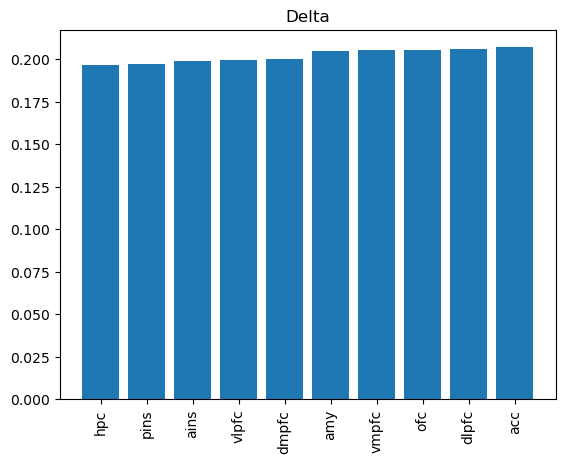

In [146]:
######## delta means by roi plot

delta_df = pd.DataFrame({'rois':delta_means.keys(),'coh':delta_means.values()}).sort_values('coh')

plt.bar(delta_df.rois, delta_df.coh)
plt.xticks(rotation=90)
plt.title('Delta')
plt.show()


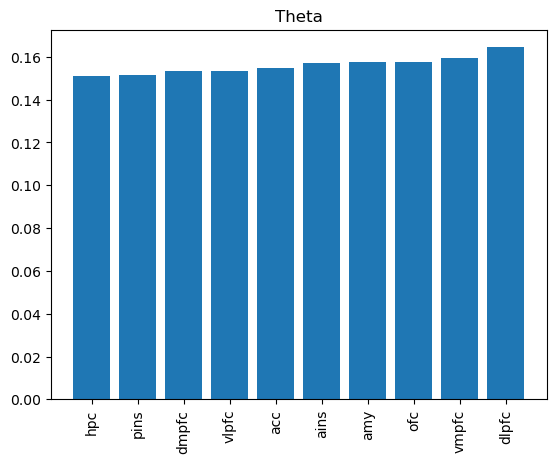

In [145]:
######## theta means by roi plot


theta_df = pd.DataFrame({'rois':theta_means.keys(),'coh':theta_means.values()}).sort_values('coh')

plt.bar(theta_df.rois, theta_df.coh)
plt.xticks(rotation=90)
plt.title('Theta')
plt.show()


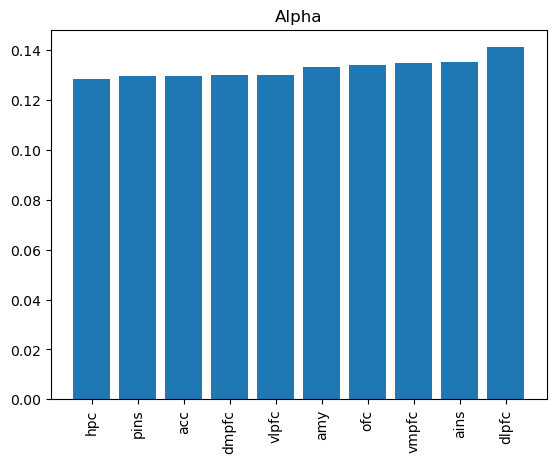

In [144]:
######## alpha means by roi plot

alpha_df = pd.DataFrame({'rois':alpha_means.keys(),'coh':alpha_means.values()}).sort_values('coh')

plt.bar(alpha_df.rois, alpha_df.coh)
plt.xticks(rotation=90)
plt.title('Alpha')
plt.show()


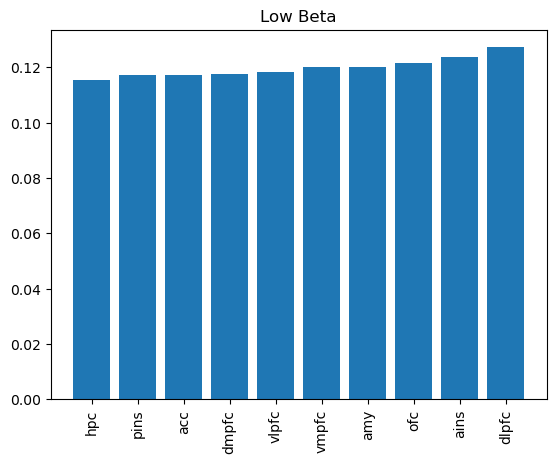

In [140]:
######## low_beta means by roi plot
low_beta_df = pd.DataFrame({'rois':low_beta_means.keys(),'coh':low_beta_means.values()}).sort_values('coh')

plt.bar(low_beta_df.rois, low_beta_df.coh)
plt.xticks(rotation=90)
plt.title('Low Beta')
plt.show()

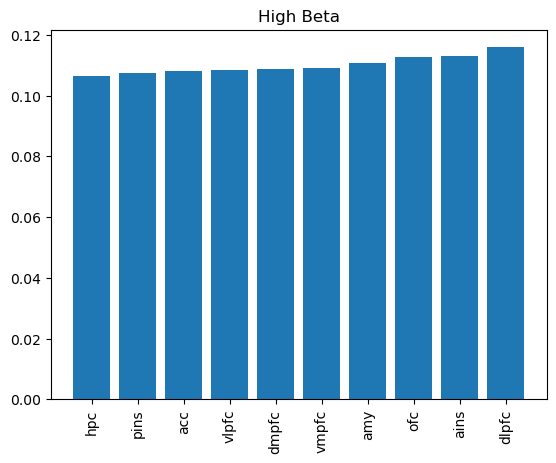

In [142]:
high_beta_df = pd.DataFrame({'rois':high_beta_means.keys(),'coh':high_beta_means.values()}).sort_values('coh')

plt.bar(high_beta_df.rois, high_beta_df.coh)
plt.xticks(rotation=90)
plt.title('High Beta')
plt.show()

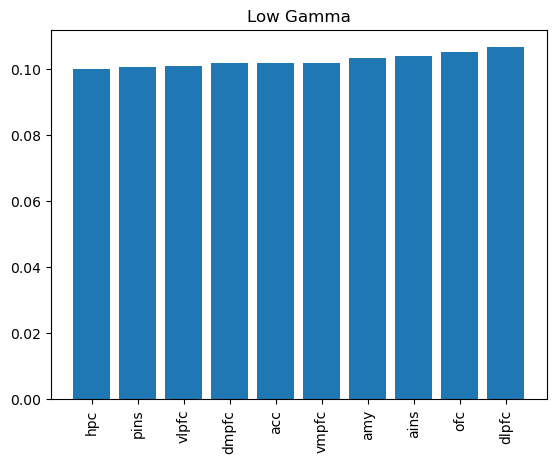

In [143]:
low_gamma_df = pd.DataFrame({'rois':low_gamma_means.keys(),'coh':low_gamma_means.values()}).sort_values('coh')

plt.bar(low_gamma_df.rois, low_gamma_df.coh)
plt.xticks(rotation=90)
plt.title('Low Gamma')
plt.show()

In [42]:
# subj_ids = list(pd.read_excel(f'{subj_info_dir}subjects_master_list.xlsx', usecols=[0]).PatientID)
# 
subj_info = pd.read_excel(f'{base_dir}patient_tracker/subjects_master_list.xlsx',usecols=[0,1,2])
subj_info

,PatientID,BDI,BAI
0,MS001,47.0,38.0
1,MS003,6.0,7.0
2,MS006,NaN,NaN
3,MS007,29.0,25.0
4,MS008,39.0,28.0
5,MS010,16.0,8.0
6,MS012,18.0,19.0
7,MS014,33.0,27.0
8,MS016,0.0,1.0
9,MS017,29.0,22.0


In [151]:
roi_info['low_beta']

,subj_id,hemi,pair_label,seed_elec,target_elec,seed_roi,target_roi,band,freq,mean_coh
1092,MS003,l,lsifo2-lsifo3:lacas2-lacas3,lsifo2-lsifo3,lacas2-lacas3,pins,pins,low_beta,16.12485,0.200132
1093,MS003,l,lsifo2-lsifo3:lacas3-lacas4,lsifo2-lsifo3,lacas3-lacas4,pins,pins,low_beta,16.12485,0.112427
1094,MS003,l,lsifo2-lsifo3:lacas4-lacas5,lsifo2-lsifo3,lacas4-lacas5,pins,pins,low_beta,16.12485,0.138917
1095,MS003,l,lsifo2-lsifo3:lacas5-lacas6,lsifo2-lsifo3,lacas5-lacas6,pins,pins,low_beta,16.12485,0.133173
1096,MS003,l,lsifo2-lsifo3:lmcms3-lmcms4,lsifo2-lsifo3,lmcms3-lmcms4,pins,pins,low_beta,16.12485,0.131190
...,...,...,...,...,...,...,...,...,...,...
2209,MS028,r,rims2-rims3:rcmmm2-rcmmm3,rims2-rims3,rcmmm2-rcmmm3,pins,pins,low_beta,16.12485,0.101188
2210,MS028,r,rims2-rims3:rcmmm3-rcmmm4,rims2-rims3,rcmmm3-rcmmm4,pins,pins,low_beta,16.12485,0.106113
2211,MS028,r,rims2-rims3:rcmmm4-rcmmm5,rims2-rims3,rcmmm4-rcmmm5,pins,pins,low_beta,16.12485,0.101695
2212,MS028,r,rims2-rims3:rcmmm5-rcmmm6,rims2-rims3,rcmmm5-rcmmm6,pins,pins,low_beta,16.12485,0.101968


In [ ]:
########## low beta by roi by subj 

low_beta_subj = {}

for roi in analysis_rois:
    roi_info = roi_freq_means[roi]
    low_beta_roi_df = roi_info['low_beta'].groupby(['subj_id'])
    low_beta_means[roi] = np.mean(low_beta_roi_df.mean_coh)
low_beta_means



# power x low_beta x ROI
low_beta = periodic_anat_max_power[periodic_anat_max_power['freq_band'] == 'low_beta']
low_beta = low_beta.groupby(['Custom']).agg({'center_freq': 'mean'}).reset_index()
low_beta = low_beta.sort_values(by='center_freq')
plt.bar(low_beta['Custom'], low_beta['center_freq'])
plt.xticks(rotation=90)
plt.title('Low Beta')
plt.show()

In [393]:
# plt.matshow(con_time.get_data(output="dense")[10, :, :, 0], fignum=0,norm='linear',cmap='viridis')

In [ ]:
#             pairwise_connectivity = np.squeeze(spectral_connectivity_time(data=mne_data, 
#                                                 freqs=freqs[(freqs>=band[0]) & (freqs<=band[1])], 
#                                                 average=False, 
#                                                 indices=indices, 
#                                                 method=metric, 
#                                                 sfreq=mne_data.info['sfreq'], 
#                                                 mode='cwt_morlet', 
#                                                 fmin=band[0], fmax=band[1], faverage=True, 
#                                                 padding=(buf_ms / 1000), 
#                                                 n_cycles=n_cycles[(freqs>=band[0]) & (freqs<=band[1])],
#                                                 gc_n_lags=15,
#                                                 verbose='warning').get_data())
#             # This returns an array of shape (n_events, n_pairs) 
#             # where n_pairs is the number of pairs of channels in indices
#             # and n_events is the number of events in the data

#             n_pairs = len(indices[0])

#             if n_pairs == 1:
#                 # reshape data
#                 pairwise_connectivity = pairwise_connectivity.reshape((pairwise_connectivity.shape[0], n_pairs))

#             if n_surr > 0:
#                 if parallelize == True:
#                     def _process_surrogate_time(ns):
#                         print(f'Computing surrogate # {ns}')
#                         surrogate_result = compute_surr_connectivity_time(mne_data, indices, metric, band, freqs, n_cycles, buf_ms)
#                         return surrogate_result

#                     surrogates = Parallel(n_jobs=-1)(delayed(_process_surrogate_time)(ns) for ns in range(n_surr))
#                     surr_struct = np.stack(surrogates, axis=-1)
#                 else:
#                     data = np.swapaxes(mne_data.get_data(), 0, 1) # swap so now it's chan, events, times 

#                     surr_struct = np.zeros([pairwise_connectivity.shape[0], n_pairs, n_surr]) # allocate space for all the surrogates 

#                     # progress_bar = tqdm(np.arange(n_surr), ascii=True, desc='Computing connectivity surrogates')

#                     for ns in range(n_surr): 
#                         print(f'Computing surrogate # {ns}')
#                         surr_dat = np.zeros_like(data) # allocate space for the surrogate channels 
#                         for ix, ch_dat in enumerate(data): # apply the same swap to every event in a channel, but differ between channels 
#                             surr_ch = swap_time_blocks(ch_dat, random_state=None)
#                             surr_dat[ix, :, :] = surr_ch
#                         surr_dat = np.swapaxes(surr_dat, 0, 1) # swap back so it's events, chan, times 
#                         # make a new EpochArray from it
#                         surr_mne = mne.EpochsArray(surr_dat, 
#                                     mne_data.info, 
#                                     tmin=mne_data.tmin, 
#                                     events = mne_data.events, 
#                                     event_id = mne_data.event_id)
                        
#                         surr_conn = np.squeeze(spectral_connectivity_time(data=surr_mne, 
#                                                     freqs=freqs[(freqs>=band[0]) & (freqs<=band[1])], 
#                                                     average=False, 
#                                                     indices=indices, 
#                                                     method=metric, 
#                                                     sfreq=surr_mne.info['sfreq'], 
#                                                     mode='cwt_morlet', 
#                                                     fmin=band[0], fmax=band[1], faverage=True, 
#                                                     padding=(buf_ms / 1000), 
#                                                     n_cycles=n_cycles[(freqs>=band[0]) & (freqs<=band[1])],
#                                                     gc_n_lags=15,
#                                                     verbose='warning').get_data())
                        
#                         if n_pairs == 1:
#                             # reshape data
#                             surr_conn = surr_conn.reshape((surr_conn.shape[0], n_pairs))

#                         surr_struct[:, :, ns] = surr_conn
#                         clear_output(wait=True)

#                 surr_mean = np.nanmean(surr_struct, axis=-1)
#                 surr_std = np.nanstd(surr_struct, axis=-1)
#                 pairwise_connectivity = (pairwise_connectivity - surr_mean) / (surr_std)
#                 # surr_struct[:, :, -1] = pairwise_connectivity # add the real data in as the last entry
#                 # z_struct = zscore(surr_struct, axis=-1) # take the zscore across surrogate runs and the real data
#                 # pairwise_connectivity = z_struct[:, :, -1] # extract the real data            

In [ ]:

# #https://mne.tools/mne-connectivity/stable/auto_examples/compare_connectivity_over_time_over_trial.html#sphx-glr-auto-examples-compare-connectivity-over-time-over-trial-py
# # Freq bands of interest
# Freq_Bands = {"theta": [4.0, 8.0], "alpha": [8.0, 13.0], "beta": [13.0, 30.0]}
# n_freq_bands = len(Freq_Bands)
# min_freq = np.min(list(Freq_Bands.values()))
# max_freq = np.max(list(Freq_Bands.values()))

# # Provide the freq points
# freqs = np.linspace(min_freq, max_freq, int((max_freq - min_freq) * 4 + 1))

# # The dictionary with frequencies are converted to tuples for the function
# fmin = tuple([list(Freq_Bands.values())[f][0] for f in range(len(Freq_Bands))])
# fmax = tuple([list(Freq_Bands.values())[f][1] for f in range(len(Freq_Bands))])

# # We will try two different connectivity measurements as an example
# connectivity_methods = ["coh", "plv"]
# n_con_methods = len(connectivity_methods)

# # Pre-allocatate memory for the connectivity matrices
# con_epochs_array = np.zeros(
#     (n_con_methods, n_channels, n_channels, n_freq_bands, n_times)
# )
# con_epochs_array[con_epochs_array == 0] = np.nan  # nan matrix

# # Compute connectivity over trials
# con_epochs = spectral_connectivity_epochs(
#     data_epoch,
#     method=connectivity_methods,
#     sfreq=sfreq,
#     mode="cwt_morlet",
#     cwt_freqs=freqs,
#     fmin=fmin,
#     fmax=fmax,
#     faverage=True,
# )

# # Get data as connectivity matrices
# for c in range(n_con_methods):
#     con_epochs_array[c] = con_epochs[c].get_data(output="dense")

    
    
    
# con_epochs_array = np.mean(con_epochs_array, axis=4)  # average over timepoints

# # In this example, we will just show alpha
# foi = list(Freq_Bands.keys()).index("alpha")  # frequency of interest


# # Define function for plotting con matrices
# def plot_con_matrix(con_data, n_con_methods):
#     """Visualize the connectivity matrix."""
#     fig, ax = plt.subplots(1, n_con_methods, figsize=(6 * n_con_methods, 6))
#     for c in range(n_con_methods):
#         # Plot with imshow
#         con_plot = ax[c].imshow(con_data[c, :, :, foi], cmap="binary", vmin=0, vmax=1)
#         # Set title
#         ax[c].set_title(connectivity_methods[c])
#         # Add colorbar
#         fig.colorbar(con_plot, ax=ax[c], shrink=0.7, label="Connectivity")
#         # Fix labels
#         ax[c].set_xticks(range(len(ch_names)))
#         ax[c].set_xticklabels(ch_names)
#         ax[c].set_yticks(range(len(ch_names)))
#         ax[c].set_yticklabels(ch_names)
#         print(
#             f"Connectivity method: {connectivity_methods[c]}\n"
#             + f"{con_data[c,:,:,foi]}"
#         )
#     return fig


# plot_con_matrix(con_epochs_array, n_con_methods)




# # Pre-allocatate memory for the connectivity matrices
# con_time_array = np.zeros(
#     (n_con_methods, n_epochs, n_channels, n_channels, n_freq_bands)
# )
# con_time_array[con_time_array == 0] = np.nan  # nan matrix

# # Compute connectivity over time
# con_time = spectral_connectivity_time(
#     data_epoch,
#     freqs,
#     method=connectivity_methods,
#     sfreq=sfreq,
#     mode="cwt_morlet",
#     fmin=fmin,
#     fmax=fmax,
#     faverage=True,
# )

# # Get data as connectivity matrices
# for c in range(n_con_methods):
#     con_time_array[c] = con_time[c].get_data(output="dense")
    
    
    
# con_time_array = np.mean(con_time_array, axis=1)  # average over epochs
# foi = list(Freq_Bands.keys()).index("alpha")  # frequency of interest

# plot_con_matrix(con_time_array, n_con_methods)

In [9]:
#connectivity plots!

# https://mne.tools/mne-connectivity/stable/auto_examples/mne_inverse_label_connectivity.html#sphx-glr-auto-examples-mne-inverse-label-connectivity-py

#https://mne.tools/mne-connectivity/stable/auto_examples/mixed_source_space_connectivity.html#sphx-glr-auto-examples-mixed-source-space-connectivity-py


In [ ]:

# def compute_surr_connectivity_time(mne_data, indices, metric, band, freqs, n_cycles, buf_ms):

#     n_pairs = len(indices[0])
#     data = np.swapaxes(mne_data.get_data(), 0, 1) # swap so now it's chan, events, times 

#     surr_dat = np.zeros_like(data) # allocate space for the surrogate channels 

#     for ix, ch_dat in enumerate(data): # apply the same swap to every event in a channel, but differ between channels 
#         surr_ch = swap_time_blocks(ch_dat, random_state=None)
#         surr_dat[ix, :, :] = surr_ch

#     surr_dat = np.swapaxes(surr_dat, 0, 1) # swap back so it's events, chan, times 

#     # make a new EpochArray from it
#     surr_mne = mne.EpochsArray(surr_dat, 
#                 mne_data.info, 
#                 tmin=mne_data.tmin, 
#                 events = mne_data.events, 
#                 event_id = mne_data.event_id)
    
#     surr_conn = np.squeeze(spectral_connectivity_time(data=surr_mne, 
#                                 freqs=freqs[(freqs>=band[0]) & (freqs<=band[1])], 
#                                 average=False, 
#                                 indices=indices, 
#                                 method=metric, 
#                                 sfreq=surr_mne.info['sfreq'], 
#                                 mode='cwt_morlet', 
#                                 fmin=band[0], fmax=band[1], faverage=True, 
#                                 padding=(buf_ms / 1000), 
#                                 n_cycles=n_cycles[(freqs>=band[0]) & (freqs<=band[1])],
#                                 gc_n_lags=15,
#                                 verbose='warning').get_data())
    
#     if n_pairs == 1:
#         # reshape data
#         surr_conn = surr_conn.reshape((surr_conn.shape[0], n_pairs))

#     return surr_conn


# def compute_connectivity(mne_data=None, 
#                         band=None,
#                         metric=None, 
#                         indices=None, 
#                         freqs=None, 
#                         n_cycles=None, 
#                         buf_ms=1000, 
#                         avg_over_dim='time',
#                         n_surr=500,
#                         parallelize=False,
#                         band1=None):
#     """
#     Compute different connectivity metrics using mne.
#     :param eeg_mne: MNE formatted EEG
#     :param samplerate: sample rate of the data
#     :param band: tuple of band of interest
#     :param metric: 'psi' for directional, or for non_directional: ['coh', 'cohy', 'imcoh', 'plv', 'ciplv', 'ppc', 'pli', pli2_unbiased', 'dpli', 'wpli', 'wpli2_debiased']
#     see: https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.spectral_connectivity_epochs.html
#     :param indices: determine the source and target for connectivity. Matters most for directional metrics i.e. 'psi'
#     :return:
#     pairwise connectivity: array of pairwise weights for the connectivity metric with some number of timepoints
#     """
#     if avg_over_dim == 'epochs':
#         if metric == 'amp': 
#             return (ValueError('Cannot compute amplitude-amplitude coupling over epochs.'))
#         if metric == 'psi': 
#             pairwise_connectivity = np.squeeze(phase_slope_index(mne_data,
#                                                                     indices=indices,
#                                                                     sfreq=mne_data.info['sfreq'],
#                                                                     mode='cwt_morlet',
#                                                                     fmin=band[0], fmax=band[1],
#                                                                     cwt_freqs=freqs,
#                                                                     cwt_n_cycles=n_cycles,
#                                                                     verbose='warning').get_data()[:, 0])
#             return pairwise_connectivity
#         else:
#             pairwise_connectivity = np.squeeze(spectral_connectivity_epochs(mne_data,
#                                                             indices=indices,
#                                                             method=metric,
#                                                             sfreq=mne_data.info['sfreq'],
#                                                             mode='cwt_morlet',
#                                                             fmin=band[0], fmax=band[1], faverage=True,
#                                                             cwt_freqs=freqs,
#                                                             cwt_n_cycles=n_cycles,
#                                                             verbose='warning').get_data()[:, 0])
#             n_pairs = len(indices[0])
#             if n_pairs == 1:
#                 # reshape data
#                 pairwise_connectivity = pairwise_connectivity.reshape((pairwise_connectivity.shape[0], n_pairs))
            
#             if n_surr > 0:
#                 if parallelize == True:
#                     def _process_surrogate_epochs(ns):
#                         print(f'Computing surrogate # {ns}')
#                         surrogate_result = compute_surr_connectivity_epochs(mne_data, indices, metric, band, freqs, n_cycles)
#                         return surrogate_result

#                     surrogates = Parallel(n_jobs=-1)(delayed(_process_surrogate_epochs)(ns) for ns in range(n_surr))
#                     surr_struct = np.stack(surrogates, axis=-1)
#                 else: 
#                     data = np.swapaxes(mne_data.get_data(), 0, 1) # swap so now it's chan, events, times 

#                     surr_struct = np.zeros([pairwise_connectivity.shape[0], n_pairs, n_surr]) # allocate space for all the surrogates 

#                     # progress_bar = tqdm(np.arange(n_surr), ascii=True, desc='Computing connectivity surrogates')

#                     for ns in range(n_surr): 
#                         print(f'Computing surrogate # {ns}')
#                         surr_dat = np.zeros_like(data) # allocate space for the surrogate channels 
#                         for ix, ch_dat in enumerate(data): # apply the same swap to every event in a channel, but differ between channels 
#                             surr_ch = swap_time_blocks(ch_dat, random_state=None)
#                             surr_dat[ix, :, :] = surr_ch
#                         surr_dat = np.swapaxes(surr_dat, 0, 1) # swap back so it's events, chan, times 
#                         # make a new EpochArray from it
#                         surr_mne = mne.EpochsArray(surr_dat, 
#                                     mne_data.info, 
#                                     tmin=mne_data.tmin, 
#                                     events = mne_data.events, 
#                                     event_id = mne_data.event_id)

#                         surr_conn = np.squeeze(spectral_connectivity_epochs(surr_mne,
#                                                                         indices=indices,
#                                                                         method=metric,
#                                                                         sfreq=surr_mne.info['sfreq'],
#                                                                         mode='cwt_morlet',
#                                                                         fmin=band[0], fmax=band[1], faverage=True,
#                                                                         cwt_freqs=freqs,
#                                                                         cwt_n_cycles=n_cycles,
#                                                                         verbose='warning').get_data()[:, 0])
#                         if n_pairs == 1:
#                             # reshape data
#                             surr_conn = surr_conn.reshape((surr_conn.shape[0], n_pairs))

#                         surr_struct[:, :, ns] = surr_conn
#                         clear_output(wait=True)

#                 surr_mean = np.nanmean(surr_struct, axis=-1)
#                 surr_std = np.nanstd(surr_struct, axis=-1)
#                 pairwise_connectivity = (pairwise_connectivity - surr_mean) / (surr_std)
                
#                 # surr_struct[:, :, -1] = pairwise_connectivity # add the real data in as the last entry 
#                 # z_struct = zscore(surr_struct, axis=-1) # take the zscore across surrogate runs and the real data 
#                 # pairwise_connectivity = z_struct[:, :, -1] # extract the real data
#     elif avg_over_dim == 'time':    
#         if metric == 'psi': 
#             return (ValueError('Cannot compute psi over time.'))
#         elif metric == 'amp': 
            
#             # crop the buffer first:
#             buf_s = buf_ms / 1000
#             mne_data.crop(tmin=mne_data.tmin + buf_s,
#                           tmax=mne_data.tmax - buf_s)

#             pairwise_connectivity = amp_amp_coupling(mne_data, 
#                                                      indices, 
#                                                      freqs0=band,
#                                                      freqs1=band1)
#             n_pairs = len(indices[0])

#             if n_pairs == 1:
#                 # reshape data
#                 pairwise_connectivity = pairwise_connectivity.reshape((pairwise_connectivity.shape[0], n_pairs))

#             if n_surr > 0:
#                 data = np.swapaxes(mne_data.get_data(), 0, 1) # swap so now it's chan, events, times 

#                 surr_struct = np.zeros([pairwise_connectivity.shape[0], n_pairs, n_surr]) # allocate space for all the surrogates 

#                 # progress_bar = tqdm(np.arange(n_surr), ascii=True, desc='Computing connectivity surrogates')

#                 for ns in range(n_surr): 
#                     print(f'Computing surrogate # {ns}')
#                     surr_dat = np.zeros_like(data) # allocate space for the surrogate channels 
#                     for ix, ch_dat in enumerate(data): # apply the same swap to every event in a channel, but differ between channels 
#                         surr_ch = swap_time_blocks(ch_dat, random_state=None)
#                         surr_dat[ix, :, :] = surr_ch
#                     surr_dat = np.swapaxes(surr_dat, 0, 1) # swap back so it's events, chan, times 
#                     # make a new EpochArray from it
#                     surr_mne = mne.EpochsArray(surr_dat, 
#                                 mne_data.info, 
#                                 tmin=mne_data.tmin, 
#                                 events = mne_data.events, 
#                                 event_id = mne_data.event_id)

#                     surr_conn = amp_amp_coupling(surr_mne, 
#                                                  indices, 
#                                                  freqs0=band,
#                                                  freqs1=band1)
#                     if n_pairs == 1:
#                         # reshape data
#                         surr_conn = surr_conn.reshape((surr_conn.shape[0], n_pairs))

#                     surr_struct[:, :, ns] = surr_conn
#                     clear_output(wait=True)

#                 surr_mean = np.nanmean(surr_struct, axis=-1)
#                 surr_std = np.nanstd(surr_struct, axis=-1)
#                 pairwise_connectivity = (pairwise_connectivity - surr_mean) / (surr_std)
#                 # surr_struct[:, :, -1] = pairwise_connectivity # add the real data in as the last entry
#                 # z_struct = zscore(surr_struct, axis=-1) # take the zscore across surrogate runs and the real data
#                 # pairwise_connectivity = z_struct[:, :, -1] # extract the real data      

#         else:
#             pairwise_connectivity = np.squeeze(spectral_connectivity_time(data=mne_data, 
#                                                 freqs=freqs[(freqs>=band[0]) & (freqs<=band[1])], 
#                                                 average=False, 
#                                                 indices=indices, 
#                                                 method=metric, 
#                                                 sfreq=mne_data.info['sfreq'], 
#                                                 mode='cwt_morlet', 
#                                                 fmin=band[0], fmax=band[1], faverage=True, 
#                                                 padding=(buf_ms / 1000), 
#                                                 n_cycles=n_cycles[(freqs>=band[0]) & (freqs<=band[1])],
#                                                 gc_n_lags=15,
#                                                 verbose='warning').get_data())
#             # This returns an array of shape (n_events, n_pairs) 
#             # where n_pairs is the number of pairs of channels in indices
#             # and n_events is the number of events in the data

#             n_pairs = len(indices[0])

#             if n_pairs == 1:
#                 # reshape data
#                 pairwise_connectivity = pairwise_connectivity.reshape((pairwise_connectivity.shape[0], n_pairs))

#             if n_surr > 0:
#                 if parallelize == True:
#                     def _process_surrogate_time(ns):
#                         print(f'Computing surrogate # {ns}')
#                         surrogate_result = compute_surr_connectivity_time(mne_data, indices, metric, band, freqs, n_cycles, buf_ms)
#                         return surrogate_result

#                     surrogates = Parallel(n_jobs=-1)(delayed(_process_surrogate_time)(ns) for ns in range(n_surr))
#                     surr_struct = np.stack(surrogates, axis=-1)
#                 else:
#                     data = np.swapaxes(mne_data.get_data(), 0, 1) # swap so now it's chan, events, times 

#                     surr_struct = np.zeros([pairwise_connectivity.shape[0], n_pairs, n_surr]) # allocate space for all the surrogates 

#                     # progress_bar = tqdm(np.arange(n_surr), ascii=True, desc='Computing connectivity surrogates')

#                     for ns in range(n_surr): 
#                         print(f'Computing surrogate # {ns}')
#                         surr_dat = np.zeros_like(data) # allocate space for the surrogate channels 
#                         for ix, ch_dat in enumerate(data): # apply the same swap to every event in a channel, but differ between channels 
#                             surr_ch = swap_time_blocks(ch_dat, random_state=None)
#                             surr_dat[ix, :, :] = surr_ch
#                         surr_dat = np.swapaxes(surr_dat, 0, 1) # swap back so it's events, chan, times 
#                         # make a new EpochArray from it
#                         surr_mne = mne.EpochsArray(surr_dat, 
#                                     mne_data.info, 
#                                     tmin=mne_data.tmin, 
#                                     events = mne_data.events, 
#                                     event_id = mne_data.event_id)
                        
#                         surr_conn = np.squeeze(spectral_connectivity_time(data=surr_mne, 
#                                                     freqs=freqs[(freqs>=band[0]) & (freqs<=band[1])], 
#                                                     average=False, 
#                                                     indices=indices, 
#                                                     method=metric, 
#                                                     sfreq=surr_mne.info['sfreq'], 
#                                                     mode='cwt_morlet', 
#                                                     fmin=band[0], fmax=band[1], faverage=True, 
#                                                     padding=(buf_ms / 1000), 
#                                                     n_cycles=n_cycles[(freqs>=band[0]) & (freqs<=band[1])],
#                                                     gc_n_lags=15,
#                                                     verbose='warning').get_data())
                        
#                         if n_pairs == 1:
#                             # reshape data
#                             surr_conn = surr_conn.reshape((surr_conn.shape[0], n_pairs))

#                         surr_struct[:, :, ns] = surr_conn
#                         clear_output(wait=True)

#                 surr_mean = np.nanmean(surr_struct, axis=-1)
#                 surr_std = np.nanstd(surr_struct, axis=-1)
#                 pairwise_connectivity = (pairwise_connectivity - surr_mean) / (surr_std)
#                 # surr_struct[:, :, -1] = pairwise_connectivity # add the real data in as the last entry
#                 # z_struct = zscore(surr_struct, axis=-1) # take the zscore across surrogate runs and the real data
#                 # pairwise_connectivity = z_struct[:, :, -1] # extract the real data            

#     return pairwise_connectivity

In [ ]:
    
# def swap_time_blocks(data, random_state=None):

#     """Compute surrogates by swapping time blocks.
#     This function cuts the timeseries at a random time point. Then, both time
#     blocks are swapped.
#     Parameters
#     ----------
#     data : array_like
#         Array of shape (n_chan, ..., n_times).
#     random_state : int | None
#         Fix the random state of the machine for reproducible results.
#     Returns
#     -------
#     surr : array_like
#         Swapped timeseries to use to compute the distribution of
#         permutations
#     References
#     ----------
#     Source: Bahramisharif et al. 2013 
#     Justification: https://www.sciencedirect.com/science/article/pii/S0959438814001640
#     """
    
#     if random_state is None:
#         random_state = int(np.random.randint(0, 10000, size=1))
#     rnd = np.random.RandomState(random_state)
    
#     # get the minimum / maximum shift
#     min_shift, max_shift = 1, None
#     if not isinstance(max_shift, (int, float)):
#         max_shift = data.shape[-1]
#     # random cutting point along time axis
#     cut_at = rnd.randint(min_shift, max_shift, (1,))
#     # split amplitude across time into two parts
#     surr = np.array_split(data, cut_at, axis=-1)
#     # revered elements
#     surr.reverse()
    
#     return np.concatenate(surr, axis=-1)



# def compute_surr_connectivity_epochs(mne_data, indices, metric, band, freqs, n_cycles):

#     n_pairs = len(indices[0])
#     data = np.swapaxes(mne_data.get_data(), 0, 1) # swap so now it's chan, events, times 

#     surr_dat = np.zeros_like(data) # allocate space for the surrogate channels 

#     for ix, ch_dat in enumerate(data): # apply the same swap to every event in a channel, but differ between channels 
#         surr_ch = swap_time_blocks(ch_dat, random_state=None)
#         surr_dat[ix, :, :] = surr_ch

#     surr_dat = np.swapaxes(surr_dat, 0, 1) # swap back so it's events, chan, times 

#     # make a new EpochArray from it
#     surr_mne = mne.EpochsArray(surr_dat, 
#                 mne_data.info, 
#                 tmin=mne_data.tmin, 
#                 events = mne_data.events, 
#                 event_id = mne_data.event_id)

#     surr_conn = np.squeeze(spectral_connectivity_epochs(surr_mne,
#                                                     indices=indices,
#                                                     method=metric,
#                                                     sfreq=surr_mne.info['sfreq'],
#                                                     mode='cwt_morlet',
#                                                     fmin=band[0], fmax=band[1], faverage=True,
#                                                     cwt_freqs=freqs,
#                                                     cwt_n_cycles=n_cycles,
#                                                     verbose='warning').get_data()[:, 0])
#     if n_pairs == 1:
#         # reshape data
#         surr_conn = surr_conn.reshape((surr_conn.shape[0], n_pairs))

#     return surr_conn



In [163]:
# anat_all_subj   = {}
# elec_anat_info = pd.DataFrame(columns=['subj_id','reref_ch_name','hemi','anode','cathode',
#                                        'anode_loc','cathode_loc','anode_roi','cathode_roi'])

# for subj_id in subj_ids:
#     # load subj anat file
#     anat_df = pd.read_csv(f'{anat_dir}{subj_id}_labels.csv')
#     ch_names = epochs_all_subj[subj_id].ch_names
#     # save anode/cathode channel labels 
#     anode_elecs = pd.Series(ch_names).str.split('-').str[0]
#     cathode_elecs = pd.Series(ch_names).str.split('-').str[1]
#     # filter anat_df to only include relevant electrodes for analysis 
#     anat_df['label'] = anat_df['label'].str.lower()
#     anat_df = anat_df[anat_df['label'].isin(list(anode_elecs) + list(cathode_elecs))]
#     anat_df['final_loc'] = anat_df['final_loc'].str.lower()
#     anat_df['final_loc'] = anat_df['final_loc'].str.strip()
#     # create new column with final anat location + custom roi label for elec 
# #     good_yba_rows = anat_df[anat_df['ManualExamination'].isnull()].index
# #     anat_df['final_loc'] = [row['YBA_1'].lower() if index in good_yba_rows else row['ManualExamination'].lower() 
# #                             for index, row in anat_df.iterrows()]
#     anat_df['roi'] = [roi_label_info['Custom'][np.where(row['final_loc'] == roi_label_info['Long.name'])[0]].item() 
#                       if pd.Series(row['final_loc']).isin(roi_label_info['Long.name'])[0] else float("nan")
#                       for index, row in anat_df.iterrows()]
# #     anat_df['hemi'] = [roi_label_info['Hemisphere'][np.where(row['final_loc'] == roi_label_info['Long.name'])[0]].item() 
# #                       if pd.Series(row['final_loc']).isin(roi_label_info['Long.name'])[0] else float("nan")
# #                       for index, row in anat_df.iterrows()]    
#     anat_df['hemi'] = [row['final_loc'][0] for index, row in anat_df.iterrows()]
#     anat_df['hemi'] = np.array(anat_df['hemi'].replace(['l','r'],['left','right']))
#     subj_elec_df = pd.DataFrame({'subj_id':[subj_id]*len(anode_elecs),'anode':anode_elecs,'cathode':cathode_elecs,
#                                  'reref_ch_name':[ch[0] for ch in list(zip(ch_names,anode_elecs))],
#                                  'hemi': list(anat_df['hemi'][anat_df['label'].isin(anode_elecs)]),
#                                  'anode_loc': list(anat_df['final_loc'][anat_df['label'].isin(anode_elecs)]),
#                                  'anode_roi': list(anat_df['roi'][anat_df['label'].isin(anode_elecs)]),
#                                  'cathode_loc': list(anat_df['final_loc'][anat_df['label'].isin(cathode_elecs)]),
#                                  'cathode_roi': list(anat_df['roi'][anat_df['label'].isin(cathode_elecs)])
#                                 })
#     elec_anat_info = pd.concat([elec_anat_info,subj_elec_df])
#     anat_df = anat_df[(anat_df['label'].isin(anode_elecs)) & (anat_df['final_loc']!='wm')]
#     anat_all_subj[subj_id] = anat_df


# elec_anat_info = elec_anat_info[~(elec_anat_info['anode_loc']=='wm')]
# elec_anat_info = elec_anat_info[~(elec_anat_info['anode_loc']=='oob')]
# elec_anat_info.to_csv(f'{base_dir}elec_anat_info_all_subj.csv')

